In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
with open('../../data/whoscored/data.json', 'r') as file:
    data = json.load(file)


In [11]:
events = [event for event in data['matchCentreData']['events']]
len(events)

1653

In [12]:
events_df = pd.DataFrame(pd.json_normalize(events, sep='_'))
events_df = events_df.drop(columns=['period_value', 'type_value', 'outcomeType_value', 'cardType_value', 'id'])

events_df['team_name'] = ''
events_df.loc[events_df['teamId'] == data['matchCentreData']['home']['teamId'], 'team_name'] = 'Barcelona'
events_df.loc[events_df['teamId'] == data['matchCentreData']['away']['teamId'], 'team_name'] = 'Real Madrid'

events_df.loc[events_df['second'].isna(), 'second'] = 0
events_df['tot_seconds'] = events_df.apply(lambda row: int(row['expandedMinute']) * 60 + int(row['second']), axis=1)
events_df = events_df.sort_values(by=['tot_seconds'])
print(events_df.columns)

Index(['eventId', 'minute', 'second', 'teamId', 'x', 'y', 'expandedMinute',
       'qualifiers', 'satisfiedEventsTypes', 'isTouch', 'period_displayName',
       'type_displayName', 'outcomeType_displayName', 'playerId', 'endX',
       'endY', 'goalMouthZ', 'goalMouthY', 'isGoal', 'isShot',
       'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
       'cardType_displayName', 'team_name', 'tot_seconds'],
      dtype='object')


In [269]:
def calculate_ball_control(df, half, only_play_time=False, start=None, end=None, debug=False):
    # only_play_time=True - time of fauls, substitution, corners, goal celebration is not counted to any of the team.
    
    df_half = df[df['period_displayName'] == half]

    start_half_time = df_half.iloc[0].minute
    end_half_time =  df_half.iloc[-1].minute

    if debug:
        print(f"{start_half_time=}, {end_half_time=}")

    # 2nd time starts from 45 min, we need to calculate margin from additional time in 1st half
    expanded_time = 0
    if half == 'SecondHalf':
        expanded_time = df_half.iloc[0].expandedMinute - 45
        
    if start is not None:
        if start < start_half_time or start > end_half_time:
            print(f"Invalid start time {start}. Half time: ({start_half_time} - {end_half_time})")
            return
            
        start_time_sec_exp = (start + expanded_time) * 60
    else:
        start_time_sec_exp = df_half.iloc[0].tot_seconds
        
    if end is not None:
        if end < start_half_time or end > end_half_time or (start and end < start):
            print(f"Invalid end time {end}. Half time: ({start_half_time} - {end_half_time})")
            return
            
        end_time_sec_exp = (end + expanded_time) * 60
    else:
        end_time_sec_exp = df_half.iloc[-1].tot_seconds        
    
    control_time_start = start_time_sec_exp
    control_team = ''
    control_time = {'Barcelona' : 0,
                    'Real Madrid' : 0}
    if debug:
        print(f"true minutes start end {start_time_sec_exp/60}, {end_time_sec_exp/60}")
    for _, row in df_half[df_half['tot_seconds'] > start_time_sec_exp].iterrows():
        # Clearance significantly worsen results 

        if row['tot_seconds'] > end_time_sec_exp:
            break
        # Check for events that contribute to ball control
        if row['type_displayName'] in ['Pass', 'TakeOn', 'KeeperPickup', 'ShieldBallOpp', 'Dispossessed', 'Save', 
                                        'Smother', 'BallRecovery', 'ShotOnPost', 'SavedShot', 'BallTouch', 
                                        'MissedShots', 'Challenge', 'Aerial'] and row['outcomeType_displayName'] == 'Successful':
            if control_team != row['team_name']:
                if control_team == '':
                    control_team = row['team_name']
                    control_time_start = row['tot_seconds']
                else:
                    if debug:
                        print(f"({row['minute']}:{row['second']}) event: {row['type_displayName']}, team {control_team} receives {row['tot_seconds'] - control_time_start} sec")
                    control_time[control_team] += row['tot_seconds'] - control_time_start
                    control_time_start = row['tot_seconds']
                    control_team = row['team_name']
        
        # Check for events that reset ball control
        if only_play_time:
            if row['type_displayName'] in ['Foul', 'Card', 'CornerAwarded', 'SubstitutionOn', 'SubstitutionOff'] \
                and control_team != '' \
                and row['outcomeType_displayName'] == 'Successful':
                if debug:
                    print(f"({row['minute']}:{row['second']}) event: {row['type_displayName']}, team {control_team} receives {row['tot_seconds'] - control_time_start} sec")
    
                control_time[control_team] += row['tot_seconds'] - control_time_start
                control_time_start = row['tot_seconds']
                control_team = ''

    if control_team:
        if debug:
            print(f"(end) team {control_team} receives {end_time_sec_exp - control_time_start} sec")
        control_time[control_team] += end_time_sec_exp - control_time_start


    # Calculate and update ball control percentages for each team

    sec_total = control_time['Barcelona'] + control_time['Real Madrid']
    if debug:
        print(sec_total/60, control_time)
    control_time['Barcelona'] = round(control_time['Barcelona'] / sec_total * 100)
    control_time['Real Madrid'] = round(control_time['Real Madrid'] / sec_total * 100)
    
    return control_time 
        

In [280]:
calculate_ball_control(events_df, 'FirstHalf')

{'Barcelona': 56, 'Real Madrid': 44}

In [281]:
calculate_ball_control(events_df, 'SecondHalf')

{'Barcelona': 46, 'Real Madrid': 54}

In [284]:
calculate_ball_control(events_df, 'FirstHalf', only_play_time=True)

{'Barcelona': 56, 'Real Madrid': 44}

In [285]:
calculate_ball_control(events_df, 'SecondHalf', only_play_time=True)

{'Barcelona': 49, 'Real Madrid': 51}

In [287]:
# total:
fh = calculate_ball_control(events_df, 'FirstHalf')
sh = calculate_ball_control(events_df, 'SecondHalf')
control_time_total = {'Barcelona' : (fh['Barcelona'] + sh['Barcelona']) / 2,
                      'Real Madrid' : (fh['Real Madrid'] + sh['Real Madrid']) / 2}
control_time_total

{'Barcelona': 51.0, 'Real Madrid': 49.0}

# Visualization

try to import show_stats_data() function from src/korotkova/match_data.ipynb

In [33]:
sys.path.insert(0, '../../src/korotkova')

from main_data import show_stats_data

FileNotFoundError: [Errno 2] No such file or directory: 'barca-rm.json'

This error could be fixed if 'barca-rm.json' is moved to Real-Madrid/data dir and `open('barca-rm.json', 'r')` is chaned to `open('../../data/barca-rm.json', 'r')`

This is not critical, since in final report everything will be in one file. Meanwhile just copy funtion

In [111]:
# function is taken from src/korotkova/main_data.py

import matplotlib.pyplot as plt
import re
import json
from matplotlib.font_manager import FontProperties

def show_stats_data(data: dict):
    labels = list(data.keys())
    values = list(data.values())

    def extract_numeric(value):
        if isinstance(value, str):
            # Extract numeric part using regular expression
            numeric_part = re.search(r'\d+(\.\d+)?', value)
            if numeric_part:
                return float(numeric_part.group())
        return float(value)

    float_values = [[extract_numeric(value)
                    for value in sublist] for sublist in values]

    first_team = [el[0] for el in float_values]
    second_team = [el[1] for el in float_values]

    sum_team = [first_team[i] + second_team[i]
                for i in range(min(len(first_team), len(second_team)))]

    first_team_normalized = [first_team[i] * 100 / sum_team[i]
                             for i in range(min(len(first_team), len(sum_team)))]
    second_team_normalized = [second_team[i] * 100 / sum_team[i]
                              for i in range(min(len(second_team), len(sum_team)))]

    fig, ax = plt.subplots(figsize=(10, 6))

    p1 = ax.barh(labels, first_team_normalized,
                 color='firebrick', label='Barcelona')
    p2 = ax.barh(labels, [-val for val in second_team_normalized],
                 color='skyblue', label='Real Madrid')

    for rect in p1:
        width = rect.get_width()
        ax.text(width, rect.get_y() + rect.get_height() / 2,
                f'{first_team[p1.index(rect)]}', ha='left', va='center')

    for rect in p2:
        width = rect.get_width()
        ax.text(width, rect.get_y() + rect.get_height() / 2,
                f'{second_team[p2.index(rect)]}', ha='right', va='center')

    ax.legend()
    ax.set_xticks([])
    plt.show()

## Non-play time is considered (substitution, corner, foul)

In [273]:
fh = calculate_ball_control(events_df, 'FirstHalf')
sh_start_52 = calculate_ball_control(events_df, 'SecondHalf', end=52) #end minute is not including
sh_52_63 = calculate_ball_control(events_df, 'SecondHalf', start=52, end=63)
sh_63_78 = calculate_ball_control(events_df, 'SecondHalf', start=63, end=78)
sh_78_end = calculate_ball_control(events_df, 'SecondHalf', start=78)

possession_stats = {'78 min - end match' : [sh_78_end['Barcelona'], sh_78_end['Real Madrid']],
                    '63 min - 78 min' : [sh_63_78['Barcelona'], sh_63_78['Real Madrid']],
                    '52 min - 63 min' : [sh_52_63['Barcelona'], sh_52_63['Real Madrid']],
                    '2nd half start - 52 min' : [sh_start_52['Barcelona'], sh_start_52['Real Madrid']],
                    '1st half' : [fh['Barcelona'], fh['Real Madrid']],
}

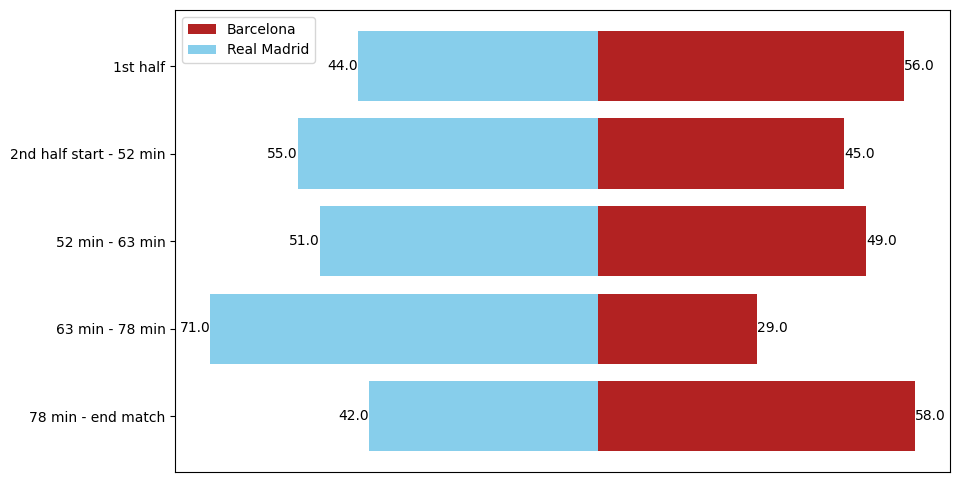

In [274]:
show_stats_data(possession_stats)

## Only play time is considered
(skip time after, foul, card, corner, substitution untill first event with the ball)

In [278]:
fh = calculate_ball_control(events_df, 'FirstHalf', only_play_time=True)
sh_start_52 = calculate_ball_control(events_df, 'SecondHalf', only_play_time=True, end=52) #end minute is not including
sh_52_63 = calculate_ball_control(events_df, 'SecondHalf', only_play_time=True, start=52, end=63)
sh_63_78 = calculate_ball_control(events_df, 'SecondHalf', only_play_time=True, start=63, end=78)
sh_78_end = calculate_ball_control(events_df, 'SecondHalf', only_play_time=True, start=78)

possession_stats = {'78 min - end match' : [sh_78_end['Barcelona'], sh_78_end['Real Madrid']],
                    '63 min - 78 min' : [sh_63_78['Barcelona'], sh_63_78['Real Madrid']],
                    '52 min - 63 min' : [sh_52_63['Barcelona'], sh_52_63['Real Madrid']],
                    '2nd half start - 52 min' : [sh_start_52['Barcelona'], sh_start_52['Real Madrid']],
                    '1st half' : [fh['Barcelona'], fh['Real Madrid']],
}

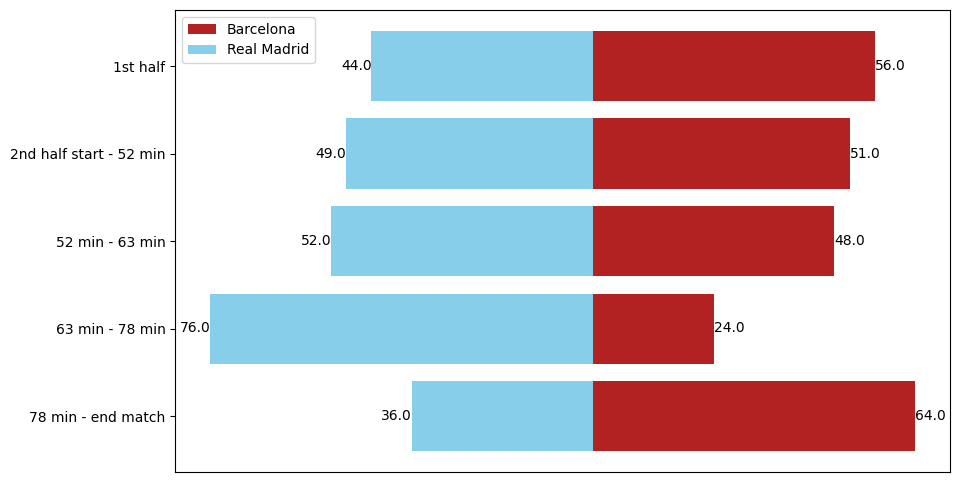

In [279]:
show_stats_data(possession_stats)